<a href="https://colab.research.google.com/github/lail-lei/AML/blob/main/project6/lailei_project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Pandas and Create DataFrames**

In [1]:
# Pandas is mainly used for data analysis. Pandas allows importing data from various file formats 
# such as comma-separated values, JSON, SQL, Microsoft Excel. 
# Pandas allows various data manipulation operations such as merging, reshaping, selecting, 
# as well as data cleaning, and data wrangling features.
import pandas as pd

# NumPy has support for large, multi-dimensional arrays and matrices, along with 
# a large collection of high-level mathematical functions to operate on these arrays.
import numpy as np

# Import matplotlib 
import matplotlib.pyplot as plt 
# Import seaborn for graphing 
import seaborn as sbn

# Read raw file from github into dataframes 
df = pd.read_csv('https://raw.githubusercontent.com/lail-lei/AML/main/project6/fetal_health.csv')


# **Preprocess Data**




In [2]:
# change values of y so they start at 0
df['fetal_health'] = df['fetal_health'] - 1

y = df['fetal_health']

y.value_counts()

0.0    1655
1.0     295
2.0     176
Name: fetal_health, dtype: int64

### **Scale Data**

In [3]:
# all x-values appear to present (nothing missing/to impute) and numeric
# let's scale the x data with standard scaler

# import scaler
from sklearn.preprocessing import StandardScaler

scaledX = df.copy(deep=True);

# drop target and categorical attributes
scaledX.drop(['fetal_health', 'histogram_tendency'], axis=1, inplace=True)

# scale X
scaler = StandardScaler()
scaler.fit(scaledX)
scaledX = pd.DataFrame(scaler.transform(scaledX), columns=scaledX.columns )

scaledX["histogram_tendency"] = df["histogram_tendency"]

scaledX.head()


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,-1.352220,-0.822388,-0.20321,-1.482465,-0.638438,-0.057476,-0.268754,1.513190,-0.943095,1.802542,-1.028560,-0.165507,-1.068562,-2.119592,-0.701397,-0.458444,-1.065614,0.153270,-1.181642,1.870569,1.0
1,-0.132526,0.730133,-0.20321,0.554627,0.375243,-0.057476,-0.268754,-1.744751,0.868841,-0.535361,0.393176,1.529124,-0.865539,1.893794,0.655137,0.958201,0.216638,0.089126,0.132038,-0.234998,0.0
2,-0.030884,-0.046128,-0.20321,1.233657,0.375243,-0.057476,-0.268754,-1.802928,0.868841,-0.535361,0.926327,1.529124,-0.865539,1.893794,0.316003,0.958201,0.216638,0.024982,-0.006244,-0.200481,0.0
3,0.070757,-0.046128,-0.20321,1.233657,0.375243,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,2.632411,1.195333,-1.373097,0.333033,2.350804,-0.458444,-0.027600,-0.039162,-0.075385,-0.200481,1.0
4,-0.132526,0.988886,-0.20321,1.233657,-0.638438,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,2.081488,1.195333,-1.373097,0.333033,1.672537,-0.458444,-0.027600,0.089126,-0.006244,-0.269516,1.0


In [4]:
# let's get a total dataframe for all data, so we can use it for selecting random sets of 400
scaledAll = scaledX.copy(deep=True);
# add targets
scaledAll["fetal_health"] = y;

### **Unscaled Data**

In [5]:
X = df.copy(deep=True);

# drop target attribute
X.drop(['fetal_health'], axis=1, inplace=True)

X.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0


### **Grouped Data**

Before we can run cross tabulation, let's group the continous data so that it can be more easily visualied in graphs. 

In [6]:
# let's group continous column values into ranges so can be visualized better 
groupedX = X.copy(deep=True)

# break each column down by quartile
def create_conditions (column):
    return [ groupedX[column] <= groupedX[column].quantile(.25), 
             groupedX[column] <= groupedX[column].quantile(.5), 
             groupedX[column] <= groupedX[column].quantile(.75),
             groupedX[column] <= groupedX[column].quantile(1.0)
            ]

# labels to correspond with quartiles
choices = [0, 1, 2, 3]

# create conditions and replace values with new labels
for col in range(20):
  conditions = create_conditions(groupedX.columns[col])
  groupedX[groupedX.columns[col]] = pd.DataFrame(np.select(conditions, choices, default=0))

In [7]:
groupedX.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,0,0,0,0,0,0,0,3,0,3,0,1,0,0,0,0,0,2,0,3,1.0
1,1,2,0,2,2,0,0,0,3,0,2,3,1,3,2,3,2,1,2,2,0.0
2,1,2,0,3,2,0,0,0,3,0,3,3,1,3,2,3,2,1,1,2,0.0
3,2,2,0,3,2,0,0,0,3,0,3,3,0,2,3,0,1,1,1,2,1.0
4,1,3,0,3,0,0,0,0,3,0,3,3,0,2,3,0,1,1,1,2,1.0


# **Preliminary Analysis**

## **Feature Correlations**

###**Correlation heatmap**

In [8]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

np.random.seed(42)

# x and y 
# data and target classes
heat_X = df.copy(deep=True)
heat_y = df["fetal_health"]

# drop target 
heat_X.drop(['fetal_health'], axis=1, inplace=True)

# use the 80-20 rule for validation
X_train, X_test, y_train, y_test = train_test_split(heat_X, heat_y, stratify=heat_y, test_size=0.2)


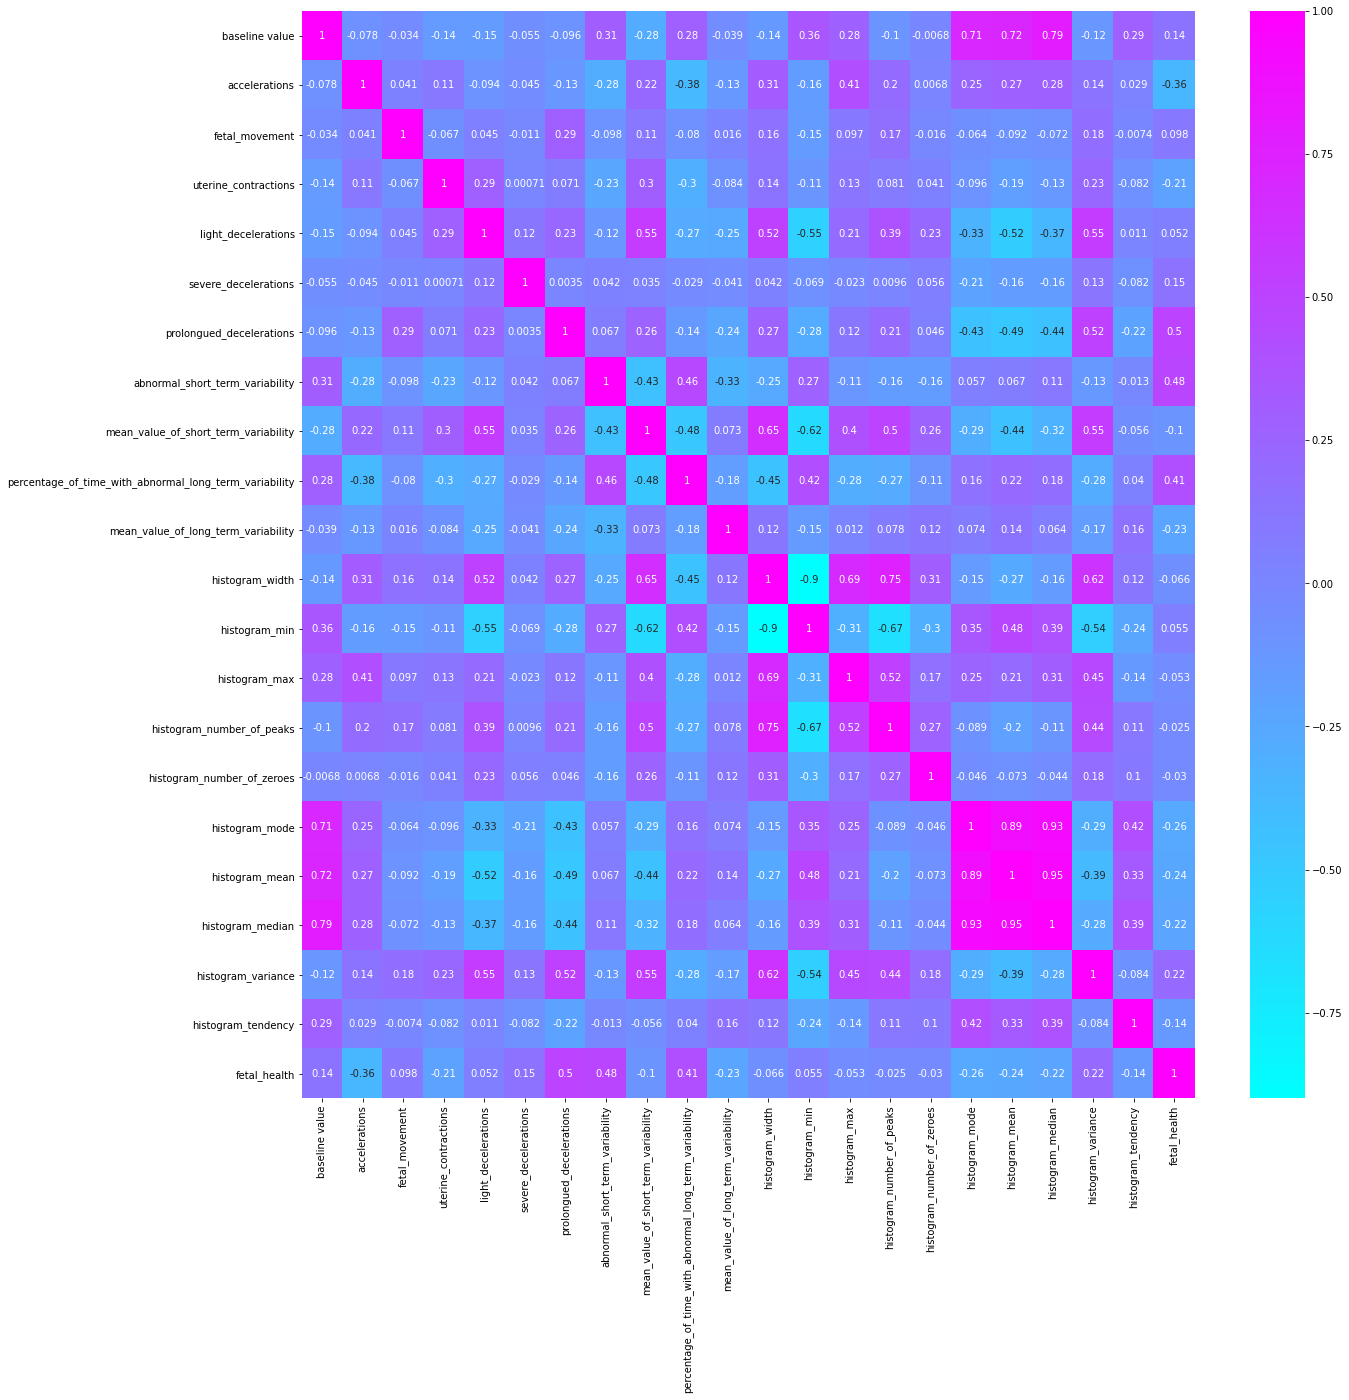

In [9]:

# produce a heatmap of feature correlations
import pandas as pd
import seaborn as sns

X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)

fig, ax = plt.subplots(figsize=(20,20)) 
g = sns.heatmap(X_comb[['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency', 'fetal_health']].corr(),
                annot=True, 
                cmap = "cool",
                ax = ax)


The feature with the strongest correlation to the target class (fetal health) is prolonged decelerations (0.5). A prolonged deceleration is defined as a deceleration in fetal heart rate that lasts more than 3 minutes. 
 
The next highest feature correlations to the target class is  abnormal short term variability (0.48), and percentage of time with abnormal long term varability (0.41).

The highest inversely correlated feature was accelerations (-0.36). Accelerations are "short-term rises in the heart rate of at least 15 beats per minute, lasting at least 15 seconds."  The inverse relationship suggests that fewer the accelerations, the higher the target class (more likely to be pathological).

These correlations seem to make sense. I'm not doctor, but prolonged deceleration and high "abnormal long term varability" in a fetus's heart rate suggests that fetus might have a weaker heart rate or an irregular heart rate. Intuitively, I would correlate weaker/irregular heart rates with poorer fetal health, and an active heart rates with better fetal health.
 

###**Cross tabulation**

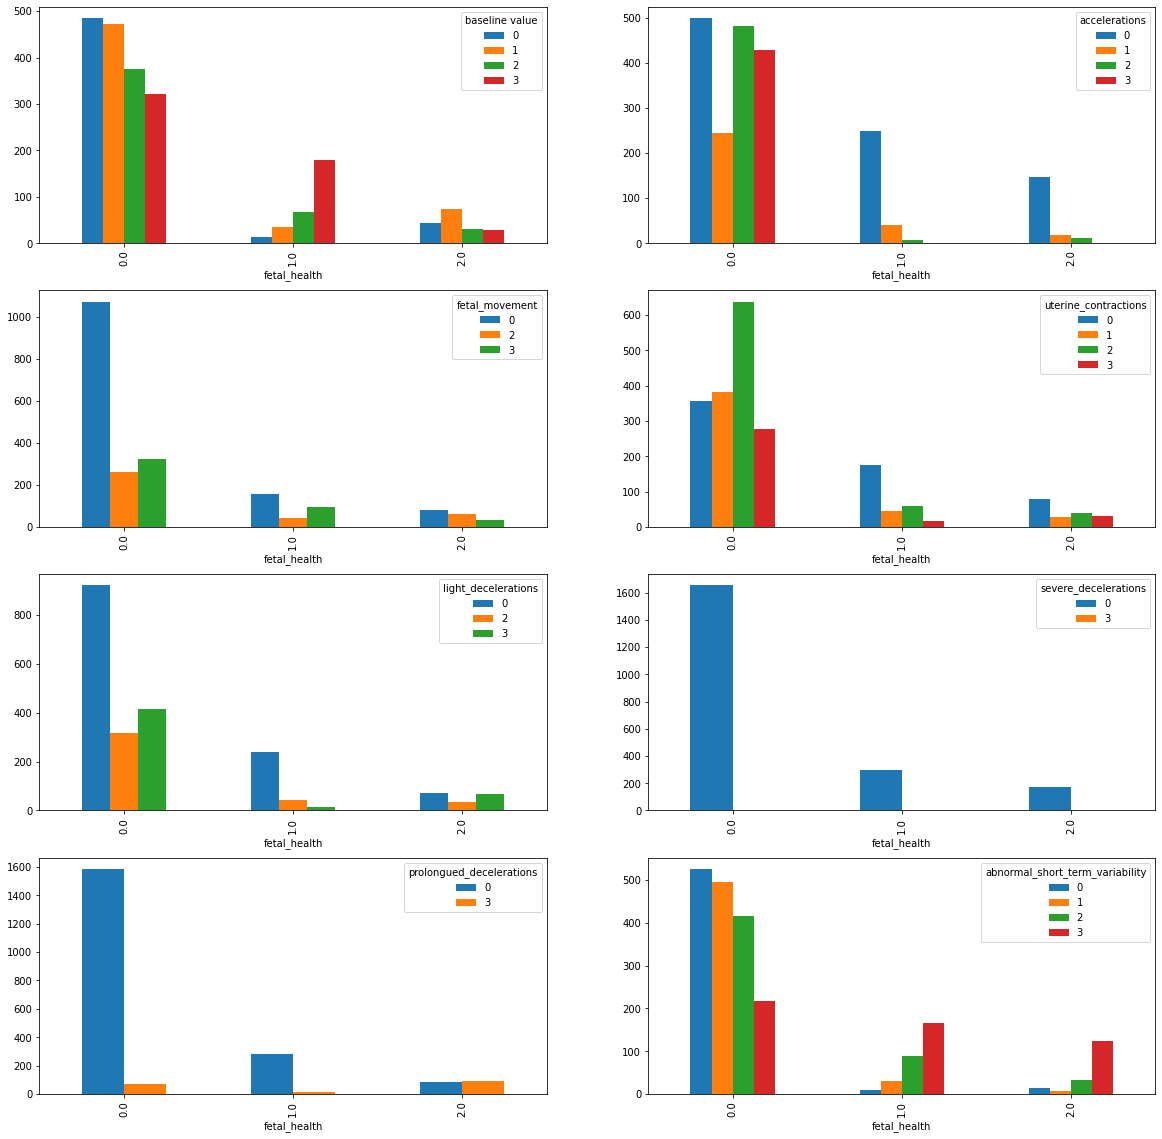

In [10]:

# display first 8 figures 
figure, axes = plt.subplots(4, 2, figsize=(20, 20))

classIndex = 0;

for row in range(4):
  for col in range(2):
    if classIndex == 8: 
      break
    ct1 = pd.crosstab(y[:], groupedX[groupedX.columns[classIndex]])
    ct1.plot.bar(ax = axes[row][col])
    classIndex += 1
    
plt.show()


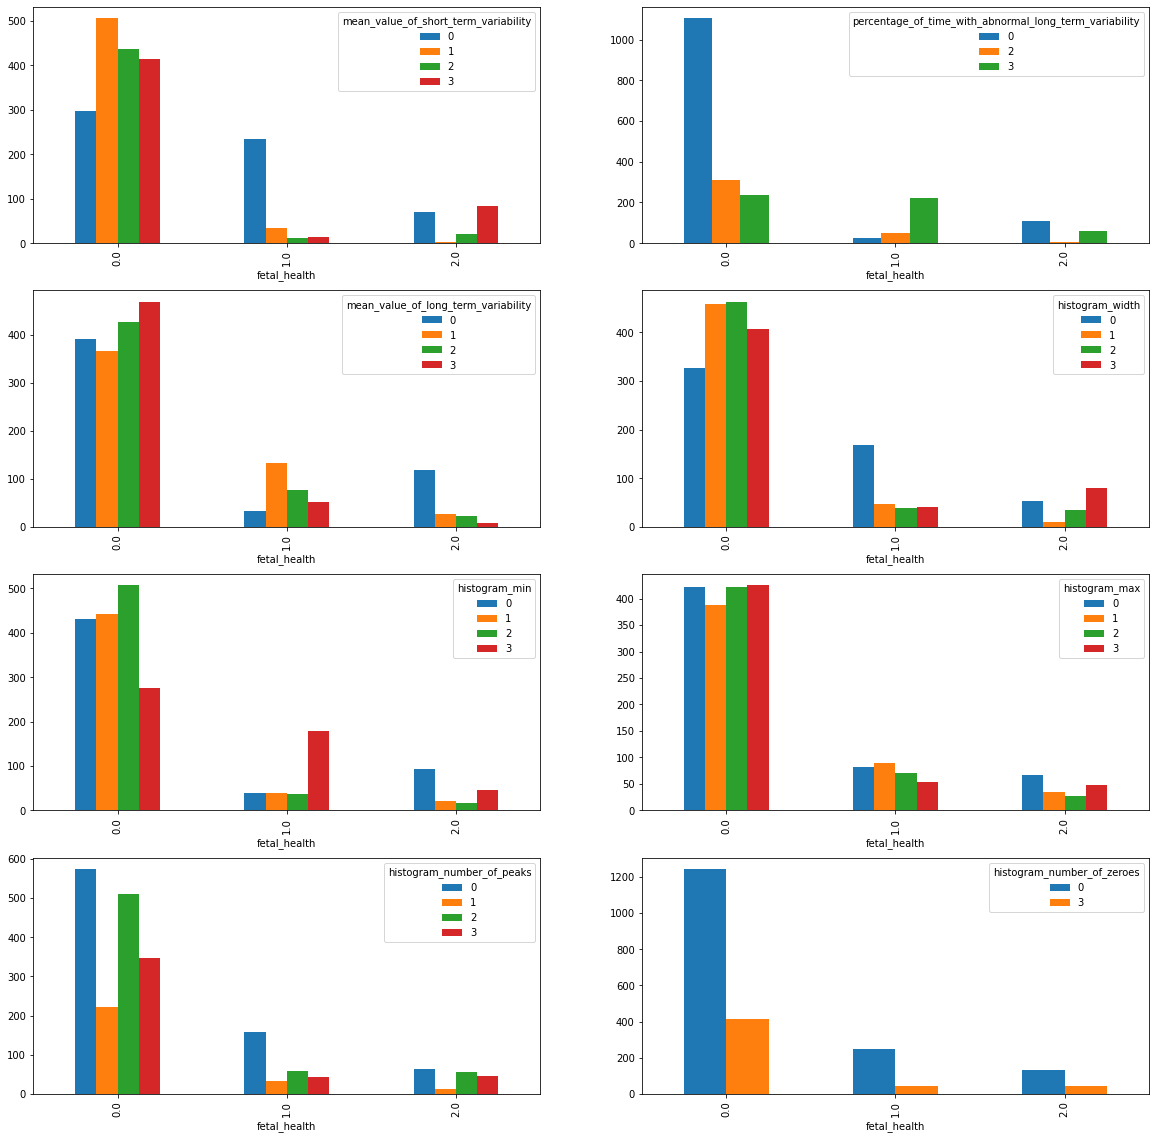

In [11]:

# display next 8 figures 
figure, axes = plt.subplots(4, 2, figsize=(20, 20))

classIndex = 8;

for row in range(4):
  for col in range(2):
    if classIndex == 16: 
      break
    ct1 = pd.crosstab(y[:], groupedX[groupedX.columns[classIndex]])
    ct1.plot.bar(ax = axes[row][col])
    classIndex += 1
    
plt.show()


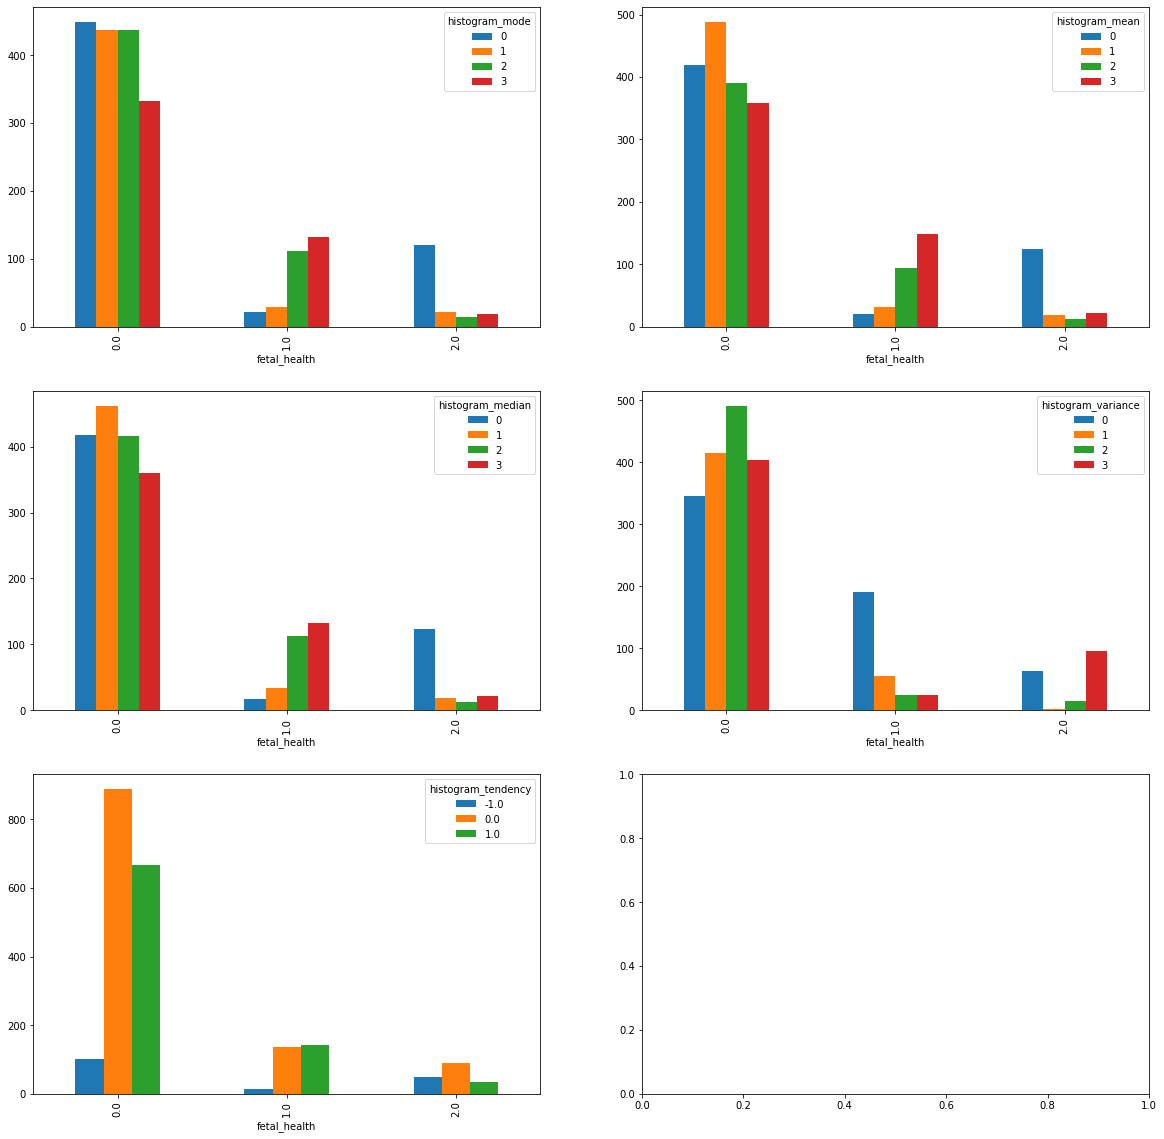

In [12]:
# display last 5 figures
figure, axes = plt.subplots(3, 2, figsize=(20, 20))

classIndex = 16;

for row in range(4):
  for col in range(2):
    if classIndex == 21: 
      break
    ct1 = pd.crosstab(y[:], groupedX[groupedX.columns[classIndex]])
    ct1.plot.bar(ax = axes[row][col])
    classIndex += 1
    
plt.show()

## **Summary**


**Grouping Data**

All attributes, with the exception of the target class and 'histogram tendency', appeared to be continuous. These continuous attributes also all had a very wide range of possible values, which made visualizing the correlations very difficult. Therefore, all features are segemented into 4 groups based on the quartile values for each feature. 

For each feature, instances in group 0 had a feature value less than or equal to the first quartile value for that feature. Instances in group 1 had a feature value between the first and second quartile values for that feature. Instances in group 2 had a feature value between the second and third quartile values. Instances in group 4 had a feature value between the third and fourth quartile values. 

**Distributions**

Not all quartile groups were well represented for some features. For example, the feature "histogram number of zeros" contained values that only fell in the first or fourth quartile. 

In general, for all features, instances of the target class 0 outnumbered instances of the target classes 1 and 2. I suspect that the lowest class (the normal fetal health class) may be overrepresented in the dataset and the suspect and pathological classes are likely underrepresented. I will confirm the target class distributions in the next section.

**Prolonged Deceleration**

The vast, vast majority of instances have a prolonged deceleration score that falls into the first quartile. Around ~1900/2126 instances had low prolonged deceleration scores. Based on the cross-tabulation graph, low prolonged deceleration scores occurred ~16x more often than high prolonged deceleration scores in healthy fetuses. Low prolonged deceleration also significantly outnumber higher scores in fetuses with "suspect" health scores. However, high deceleration scores appear to occur in more than 50% of the pathlogical fetus health class. 

Cross-tabulation seems to support the significant correlation between prolonged deceleration and the target class. The cross-tabulation graph suggests that when high prolonged deceleration scores occur, they are strongly correlated with poor fetal health.  

**Abnormal short term variability**

Instances with low (first or second quartile) abnormal short term variability scores account for ~1k / ~1.6k instances in (or about 63% of) target class 0. In target class 1, instances with high (third or fourth quartiles) scores account for ~300 instances, while low quartile scores appear to occur in ~50 cases ( ~86% higher scores). In target class 2, instances with highest scores (fourth quartile) account significantly more than lower (first, second or third quartile) scores.  

Cross-tabulation seems to support the correlation between abnormal short term variability and the target class. The cross-tabulation graph suggests that, although high scores can occur in healthy fetuses, they proportionally occur more frequently in suspect or pathlogical fetuses. 


**Accelerations**

Higher acceleration scores (third/fourth quartile) occur in ~875/ ~1.6k or 54% of instances in target class 0. Third quartile scores appear in < 50 instances in the target classes 1 and 2. Fourth quartile scores (highest acceleration scores) appear only in target class 0- there are 0 occurances of these scores in target classes 1 or 2. 

Cross-tabulation seems to support the inverse correlation between accelerations and the target class. Higher acceleration scores are much more likely to occur in healthy fetuses than suspect or pathological ones. 



## **Distributions**

In [13]:
# let's print the number of instances per target class
y.value_counts()

0.0    1655
1.0     295
2.0     176
Name: fetal_health, dtype: int64

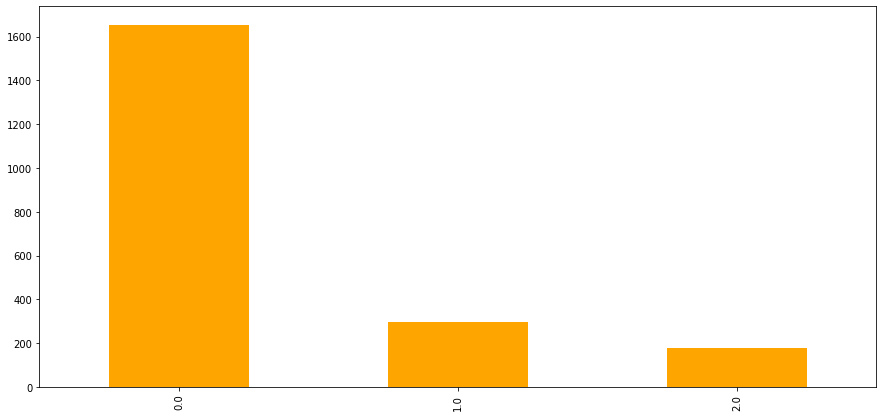

In [14]:
# get frequency per target class
label_frequencies = df['fetal_health'].value_counts().sort_index(ascending=True)

label_frequencies.plot(figsize=(15,7), kind ='bar', color="orange")

This is a very lopsided distribution! Let's see how the sequential neural model manages it. 

# **Sequential Neural Model 1**

In [15]:
# let's split the scaled data into training and testing sets

# set aside the normalized data for training and testing
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.2, random_state=22)


In [16]:
# let's create the sequential neural model

# import tensorflow and keras!
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten

# train a network with one hidden layer (50 nodes) and three output nodes
model = keras.models.Sequential([
                                 # flatten th dataframe from matrix with 21 features to 1D array of size 21
                                 keras.layers.Flatten(input_shape=[X_train.shape[1],]),
                                 # 1 hidden layer, uses relu for activation function
                                 keras.layers.Dense(50, activation="relu"),
                                 # 3 output nodes, 1 for each class
                                 # softmax for multiclass
                                 keras.layers.Dense(3, activation="softmax")
])


In [17]:
# let's print the summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 21)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1100      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,253
Trainable params: 1,253
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the model using appropriate parameters
model.compile(loss="sparse_categorical_crossentropy", # for multiclass
              optimizer="sgd",
              metrics=["accuracy"])


# fit() produces a history object that contains all the details about the classifier including accuracy scores
# experiment with epochs and batch_size to see how they affect overall accuracy
history = model.fit(X_train, y_train, epochs=19, validation_data=(X_test, y_test))


# evaulate the model 
test = model.evaluate(X_test, y_test)


Epoch 1/19
54/54 [==============================] - 1s 12ms/step - loss: 0.9291 - accuracy: 0.6274 - val_loss: 0.6744 - val_accuracy: 0.8099
Epoch 2/19
54/54 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.8209 - val_loss: 0.5523 - val_accuracy: 0.8239
Epoch 3/19
54/54 [==============================] - 0s 2ms/step - loss: 0.5230 - accuracy: 0.8331 - val_loss: 0.4816 - val_accuracy: 0.8357
Epoch 4/19
54/54 [==============================] - 0s 2ms/step - loss: 0.4581 - accuracy: 0.8501 - val_loss: 0.4362 - val_accuracy: 0.8427
Epoch 5/19
54/54 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.8528 - val_loss: 0.4048 - val_accuracy: 0.8498
Epoch 6/19
54/54 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8850 - val_loss: 0.3818 - val_accuracy: 0.8568
Epoch 7/19
54/54 [==============================] - 0s 2ms/step - loss: 0.3508 - accuracy: 0.8934 - val_loss: 0.3636 - val_accuracy: 0.8732
Epoch 8/19
54/54 [=

In [19]:
# Let's get a prediction
y_pred = model.predict_classes(X_test)  #deprecated 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [20]:
# import classification report, confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#print confusion matrix
print(confusion_matrix(y_test, y_pred))


[[329   8   0]
 [ 23  32   1]
 [  3   9  21]]


In [21]:
# print various classification performance measures
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       337
         1.0       0.65      0.57      0.61        56
         2.0       0.95      0.64      0.76        33

    accuracy                           0.90       426
   macro avg       0.84      0.73      0.77       426
weighted avg       0.89      0.90      0.89       426



Those precision scores are surprisingly good! Overall accuracy is not bad at all either! The confusion matrix looks good too. 

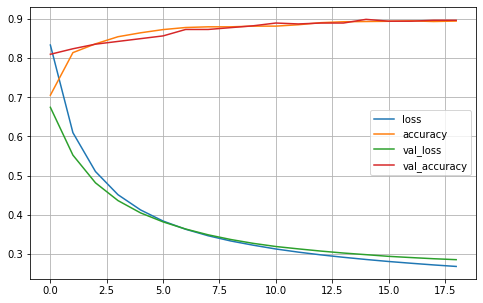

In [22]:
# the extremely close gaps between accuracy/loss and validated accuracy/loss verify that
# overfitting is not severe in the model

from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot
from numpy import where

# plot model accuracy and loss during training
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

The model's accuracy/loss and val accuracy/ val loss plot looks great. There's a very tight fit between accuracy/val accuracy and loss/val loss- so no evidence of overfitting here. 

In [23]:
# cross validation in keras is somewhat different than in sklearn

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

# create the sequential NN model
def create_baseline():
    # train a network with one hidden layer (50 nodes) and three output nodes
    model = keras.models.Sequential([
                                    # flatten th dataframe from matrix with 21 features to 1D array of size 21
                                    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
                                    # 1 hidden network, uses relu for activation function
                                    keras.layers.Dense(50, activation="relu"),
                                    # 3 output nodes, 1 for each class
                                    # softmax for multiclass
                                    keras.layers.Dense(3, activation="softmax")
    ])
    # Compile the model using appropriate parameters
    model.compile(loss="sparse_categorical_crossentropy", # for multiclass
              optimizer="sgd",
              metrics=["accuracy"])
    return model


# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=150, verbose=0)

# do a 3-fold CV on the entire dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, scaledX, y, cv=kfold)

print("Baseline accuracy: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))

Baseline accuracy: 90.50% (+/- 0.46%)


**Summary**

**Cross Validated Model's mean accuracy**

A baseline accuracy of 90.5% is excellent, considering the lopsided distribution of the target classes. To get a better idea of how well the model classified each class, I analyzed the confusion matrix/report from my first run of the neural network.

**First run of the sequential neural network**

I took screenshots of confusion matrix/classification report for the first run of my sequential network- they were lost when the runtime was disconnected and restarted. The values in them should be similiar to the ones above, but I wrote my analysis for these numbers:

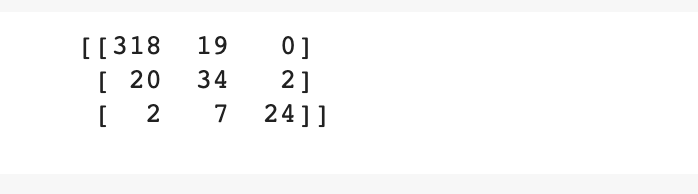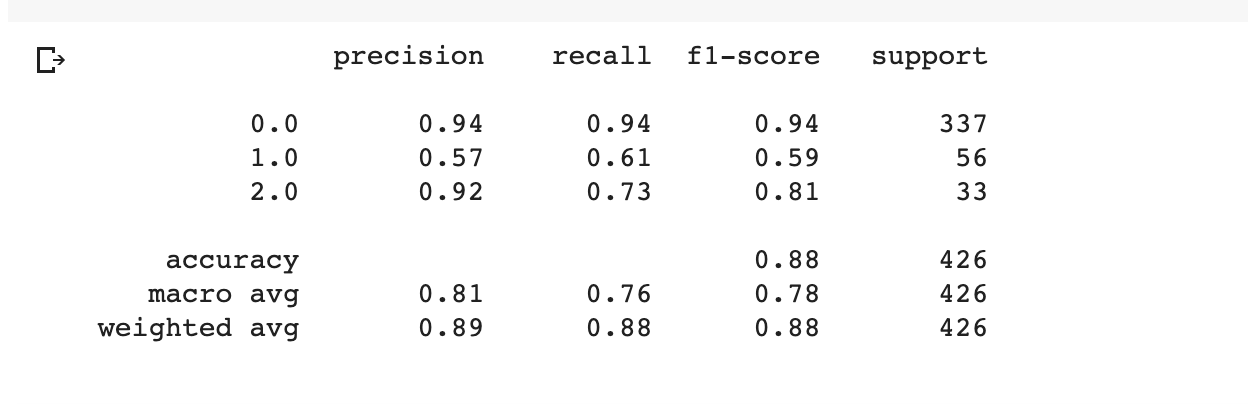

Considering the uneven distributions, this sequential model performed surprisingly well- especially for the normal and pathological classes. Class 0 (normal) had a precision, recall, and f1-score of 94%. Class 2 (pathological) had high precision (92%), but a lower recall at 73%. 

When an instance was pathological, the model did a pretty good job of classifying it as such.  

I think the model's performance for the pathological class is particularly impressive when considering the small number of samples - only 26. The two misclassified pathological instances were classified as suspect. More suspect cases than healthy cases were misclassified as pathological. No pathological cases at all were misclassified as healthy. In real world applications, the mistakes the model made might not be necessarily bad mistakes (it's better to mark a suspected or healthy person as sick than a sick person as healthy). 

Class 1 (suspect) had the worst performance overall. It's precison score was 35% less than Class 2, despite having double the number of instances in the testing set (60 suspect vs 24 pathological). This suggests that pathological features are intensely predictive and create strong distinctions between the pathological class and the normal and suspect classes. 

# **Parameter Optimization**

In [68]:
# cross validation with multiple layers 

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

# create the sequential NN model
def create_baseline():
    # train a network with three hidden layer (50 nodes) and three output node
    model = keras.models.Sequential([
                                    # flatten th dataframe from matrix with 21 features to 1D array of size 21
                                    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
                                    # 1 hidden layer, uses relu for activation function
                                    keras.layers.Dense(50, activation="relu"),
                                    keras.layers.Dense(50, activation="relu"),
                                    keras.layers.Dense(50, activation="relu"),
                                    keras.layers.Dense(50, activation="relu"),
                                    # 3 output nodes, 1 for each class
                                    # softmax for multiclass
                                    keras.layers.Dense(3, activation="softmax")
    ])
    # Compile the model using appropriate parameters
    model.compile(loss="sparse_categorical_crossentropy", # for multiclass
              optimizer="sgd",
              metrics=["accuracy"])
    return model


# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=150, verbose=0)

# do a 3-fold CV on the entire dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, scaledX, y, cv=kfold)

print("Baseline accuracy: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))

Baseline accuracy: 91.82% (+/- 0.12%)


In [57]:
# cross validation with fewer nodes

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

# create the sequential NN model
def create_baseline():
    # train a network with three hidden layer (10 nodes) and three output nodes
    model = keras.models.Sequential([
                                    # flatten th dataframe from matrix with 21 features to 1D array of size 21
                                    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
                                    # 1 hidden layer, uses relu for activation function
                                    keras.layers.Dense(10, activation="relu"),
                                    # 3 output nodes, 1 for each class
                                    # softmax for multiclass
                                    keras.layers.Dense(3, activation="softmax")
    ])
    # Compile the model using appropriate parameters
    model.compile(loss="sparse_categorical_crossentropy", # for multiclass
              optimizer="sgd",
              metrics=["accuracy"])
    return model


# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=150, verbose=0)

# do a 3-fold CV on the entire dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, scaledX, y, cv=kfold)

print("Baseline accuracy: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))

Baseline accuracy: 89.37% (+/- 0.84%)


In [60]:
# cross validation with more nodes

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

# create the sequential NN model
def create_baseline():
    # train a network with 1 hidden layer (250 nodes) and one output node
    model = keras.models.Sequential([
                                    # flatten th dataframe from matrix with 21 features to 1D array of size 21
                                    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
                                    # 1 hidden layer, uses relu for activation function
                                    keras.layers.Dense(250, activation="relu"),
                                    # 3 output nodes, 1 for each class
                                    # softmax for multiclass
                                    keras.layers.Dense(3, activation="softmax")
    ])
    # Compile the model using appropriate parameters
    model.compile(loss="sparse_categorical_crossentropy", # for multiclass
              optimizer="sgd",
              metrics=["accuracy"])
    return model


# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=150, verbose=0)

# do a 3-fold CV on the entire dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, scaledX, y, cv=kfold)

print("Baseline accuracy: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))

Baseline accuracy: 90.73% (+/- 0.83%)


In [71]:
# cross validation with multiple layers and different #s of nodes

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

# create the sequential NN model
def multi_node_multi_layer():
    # train a network with three hidden layer (50 nodes) and three output node
    model = keras.models.Sequential([
                                    # flatten th dataframe from matrix with 21 features to 1D array of size 21
                                    keras.layers.Flatten(input_shape=[X_train.shape[1],]),
                                    # 1 hidden layer, uses relu for activation function
                                    keras.layers.Dense(100, activation="relu"),
                                    keras.layers.Dense(75, activation="relu"),
                                    keras.layers.Dense(50, activation="relu"),
                                    keras.layers.Dense(25, activation="relu"),
                                    keras.layers.Dense(10, activation="relu"),
                                    # 3 output nodes, 1 for each class
                                    # softmax for multiclass
                                    keras.layers.Dense(3, activation="softmax")
    ])
    # Compile the model using appropriate parameters
    model.compile(loss="sparse_categorical_crossentropy", # for multiclass
              optimizer="sgd",
              metrics=["accuracy"])
    return model


# evaluate model with standardized dataset
nodes_layers_estimator = KerasClassifier(build_fn=multi_node_multi_layer, epochs=150, verbose=0)

# do a 3-fold CV on the entire dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, scaledX, y, cv=kfold)

print("Baseline accuracy: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))

Baseline accuracy: 92.66% (+/- 1.04%)


In [83]:
#let's do grid search for batch size and epochs

#import
from sklearn.model_selection import GridSearchCV

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100, 150, 250]
# params dict
param_grid = dict(batch_size=batch_size, epochs=epochs)

# do a 3-fold CV on the entire dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#fit the model
grid = GridSearchCV(estimator=nodes_layers_estimator, param_grid=param_grid, n_jobs=1, cv=kfold)
grid_result = grid.fit(scaledX, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.934144 using {'batch_size': 20, 'epochs': 250}


Using 5 hidden layers, with a descending number of nodes in each layer (from 100 to 10), and 150 epochs, the sequential neural network was able to get an accuracy score of 93%! (Activation functions for hidden layers were relu, and softmax for output).

#**Binarized Target Class: Normal vs Suspect/Pathological**

In [164]:
# since the model performed very well on pathological and healthy cases, let's try combining 
# pathological and suspect 
binary = scaledAll.copy(deep=True)

# binarize the y
binary.loc[(df.fetal_health == 2),'fetal_health']= 1;

# bin X
binary_X = binary.drop(columns=['fetal_health'])

# bin Y
binary_y = binary["fetal_health"]


In [165]:
# now there is 471 pathological and 1655 non pathlogical
binary_y.value_counts()

0.0    1655
1.0     471
Name: fetal_health, dtype: int64

In [166]:
# let's split the binary, scaled data into training and testing sets
# set aside the normalized data for training and testing
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(binary_X, binary_y, test_size=0.2, random_state=22)

In [167]:
# how many values are in what 
bin_y_test.value_counts()

0.0    337
1.0     89
Name: fetal_health, dtype: int64

In [168]:
# single binary model
bin_model = keras.models.Sequential([
                                    # flatten th dataframe from matrix with 21 features to 1D array of size 21
                                    keras.layers.Flatten(input_shape=[bin_X_train.shape[1],]),
                                    # 1 hidden layer, uses relu for activation function
                                    keras.layers.Dense(50, activation="relu"),
                                    # 1 output node
                                    # sigmoid for binary
                                    keras.layers.Dense(1, activation="sigmoid")
    ])
# Compile the model using appropriate parameters
bin_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [169]:

# fit() produces a history object that contains all the details about the classifier including accuracy scores
# experiment with epochs and batch_size to see how they affect overall accuracy
bin_history = bin_model.fit(bin_X_train, bin_y_train, epochs=19, validation_data=(bin_X_test, bin_y_test))


# evaulate the model 
test = bin_model.evaluate(bin_X_test, bin_y_test)


Epoch 1/19
54/54 [==============================] - 1s 6ms/step - loss: 0.6486 - accuracy: 0.6129 - val_loss: 0.4258 - val_accuracy: 0.8685
Epoch 2/19
54/54 [==============================] - 0s 2ms/step - loss: 0.3745 - accuracy: 0.8896 - val_loss: 0.3198 - val_accuracy: 0.8920
Epoch 3/19
54/54 [==============================] - 0s 2ms/step - loss: 0.2884 - accuracy: 0.9036 - val_loss: 0.2733 - val_accuracy: 0.8991
Epoch 4/19
54/54 [==============================] - 0s 2ms/step - loss: 0.2410 - accuracy: 0.9125 - val_loss: 0.2497 - val_accuracy: 0.9108
Epoch 5/19
54/54 [==============================] - 0s 2ms/step - loss: 0.2123 - accuracy: 0.9205 - val_loss: 0.2360 - val_accuracy: 0.9085
Epoch 6/19
54/54 [==============================] - 0s 2ms/step - loss: 0.2177 - accuracy: 0.9090 - val_loss: 0.2287 - val_accuracy: 0.9061
Epoch 7/19
54/54 [==============================] - 0s 2ms/step - loss: 0.1935 - accuracy: 0.9170 - val_loss: 0.2229 - val_accuracy: 0.9085
Epoch 8/19
54/54 [==

In [170]:
# Let's get a prediction
bin_y_pred = bin_model.predict_classes(bin_X_test)  #deprecated 

#print confusion matrix
print(confusion_matrix(bin_y_test, bin_y_pred))

[[321  16]
 [ 23  66]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [171]:
# print various classification performance measures
print(classification_report(bin_y_test, bin_y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       337
         1.0       0.80      0.74      0.77        89

    accuracy                           0.91       426
   macro avg       0.87      0.85      0.86       426
weighted avg       0.91      0.91      0.91       426



The binary model appears to have a higher overall accuracy (91% vs 88%). It's precision/recall in classifiying the normal class is largely the same as the multiclass model's. The combined pathological/suspect class has a precision of 81% - lower than the pathological classes's precision (92-95%), but higher than the suspect classes precision (57-60%). 

# **Binarized Target Class: Non-pathological vs Pathological**

In [194]:
# since the model performed very well on pathological and healthy cases, let's try combining 
# normal and suspect 
binary2 = scaledAll.copy(deep=True)

# binarize the y
binary2.loc[(df.fetal_health == 1),'fetal_health']= 0;
binary2.loc[(df.fetal_health == 2),'fetal_health']= 1;

# bin X
binary_X2 = binary2.drop(columns=['fetal_health'])

# bin Y
binary_y2 = binary2["fetal_health"]

In [195]:
# let's split the binary, scaled data into training and testing sets
# set aside the normalized data for training and testing
bin2_X_train, bin2_X_test, bin2_y_train, bin2_y_test = train_test_split(binary_X2, binary_y2, test_size=0.2, random_state=22)

In [196]:

# fit() produces a history object that contains all the details about the classifier including accuracy scores
# experiment with epochs and batch_size to see how they affect overall accuracy
bin_history = bin_model.fit(bin2_X_train, bin2_y_train, epochs=19, validation_data=(bin2_X_test, bin2_y_test))


# evaulate the model 
test = bin_model.evaluate(bin2_X_test, bin2_y_test)


Epoch 1/19
54/54 [==============================] - 0s 5ms/step - loss: 0.7918 - accuracy: 0.9665 - val_loss: 0.8631 - val_accuracy: 0.9648
Epoch 2/19
54/54 [==============================] - 0s 3ms/step - loss: 0.7568 - accuracy: 0.9671 - val_loss: 0.8533 - val_accuracy: 0.9648
Epoch 3/19
54/54 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.9659 - val_loss: 0.8404 - val_accuracy: 0.9648
Epoch 4/19
54/54 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.9682 - val_loss: 0.8334 - val_accuracy: 0.9648
Epoch 5/19
54/54 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.9694 - val_loss: 0.8243 - val_accuracy: 0.9648
Epoch 6/19
54/54 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.9700 - val_loss: 0.8093 - val_accuracy: 0.9648
Epoch 7/19
54/54 [==============================] - 0s 3ms/step - loss: 0.6005 - accuracy: 0.9694 - val_loss: 0.8029 - val_accuracy: 0.9648
Epoch 8/19
54/54 [==

In [197]:
# target values 
bin2_y_test.value_counts()


0.0    393
1.0     33
Name: fetal_health, dtype: int64

In [198]:
# Let's get a prediction
bin2_y_pred = bin_model.predict_classes(bin2_X_test)  #deprecated 

#print confusion matrix
print(confusion_matrix(bin2_y_test, bin2_y_pred))

[[390   3]
 [  9  24]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [200]:
# print various classification performance measures
print(classification_report(bin2_y_test, bin2_y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       393
         1.0       0.89      0.73      0.80        33

    accuracy                           0.97       426
   macro avg       0.93      0.86      0.89       426
weighted avg       0.97      0.97      0.97       426



The second binary model has the highest overall accuracy (97% vs 91%, 88%). The combined normal and suspect class has an ~4% improved precision and recall (98%, 99%). It seems like binarizing the classes did more harm than good when it comes to classifying pathological cases. My intuition about this behavior is that the combination of suspect and normal scores may have increased the threshold at which the network might classify a feature value as pathological, leading to false negatives. After all, the boundary between suspect and pathological was a fuzzy one. If enough of a pathological instance's features ressemble a typical suspect (binarized as "nonpathological") instance's features, the model may consider the pathological instance "nonpathological".

# **Summary**

**Data Preparation and Distribution**

Aside from scaling, little data preparation was need (no missing values, all numeric data). The target classes were 1-indexed, so for simplicity, I converted them to a 0-index. 

The target classes had a very lopside distribution. Out of 2126 total intances, 1,655 were normal, 295 were suspect, and 176 were pathological. 

**Correlated Features**

The feature with the strongest correlations to the target class (fetal health) were prolonged decelerations (0.5), abnormal short term variability (0.48), percentage of time with abnormal long term varability (0.41), and accelerations (-0.36).

A prolonged deceleration is defined as a deceleration in fetal heart rate that lasts more than 3 minutes. Accelerations are "short-term rises in the heart rate of at least 15 beats per minute, lasting at least 15 seconds." The inverse relationship suggests that fewer the accelerations, the higher the target class (more likely to be pathological).

These correlations seem to make sense. Prolonged deceleration and high "abnormal long term varability" in a fetus's heart rate suggests that fetus might have a weaker heart rate or an irregular heart rate. Intuitively, I would correlate weaker/irregular heart rates with poorer fetal health, and an active heart rates with better fetal health.


**Sequential Neural Network for Multiclass Classification**

The sequential neural network for multiclass classification had a cross-validated mean accuracy of 90.5%. Considering the uneven distributions, this sequential model performed surprisingly well- especially for the normal and pathological classes. Class 0 (normal) had a precision, recall, and f1-score of 94%. Class 2 (pathological) had high precision (92%), but a lower recall at 73%.

The multiclass model's performance for the pathological class is particularly impressive when considering the small number of samples. When a pathological case was misclassified, it was classified as suspect (rather than normal). More suspect cases than healthy cases were misclassified as pathological. No pathological cases at all were misclassified as healthy. In real world applications, the mistakes the model made might not be necessarily bad mistakes (it's better to mark a suspected or healthy person as sick than a sick person as healthy).

Overall, the multiclass model had the worst success classifying suspect cases- even though there were more suspect cases than pathological. This suggests that pathological features are intensely predictive and create strong distinctions between the pathological class and the normal and suspect classes.

**Sequential Neural Network for Binary Classification**

To see if binarizing the data would improve model performance, I first created a normal - suspect/pathological binary and then and nonpathological (suspect and normal) - pathological binary.

While both binary models had improved overall accuracy, they both had decreased performance in classifying pathological and suspect/pathological instances. 

My intuition for the pathological/nonpathological model's behavor is that combining the suspect and normal classes blurred the boundary between normal and pathological cases. When suspect cases were marked as "normal", the "diagnositic" threshold of what the model could consider pathological may have increased, which led to more misclassifications.

In the normal vs suspected/pathological model, the behavior is a little different. The number of misclassified suspect/pathological instances appears to be similar (~23) to the number of suspect instances classified as normal in the multiclass model. This suggests that the poor performance of the suspect class in the multiclass model most likely is caused by a weak or fuzzy boundary between "normal" feature values and "suspect" ones.

For real world applications, unless the diagnosistic category "suspect" is a system requirement, it might be more performant to eliminate the "suspect" data from the model dataset, and train the model on purely "normal" and purely "pathological" data. 

